<a href="https://colab.research.google.com/github/Tej3424/Covid19/blob/main/COvid_19_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data directories
train_dir = '/content/drive/MyDrive/Covid-19 dataset/train'
validation_dir = '/content/drive/MyDrive/Covid-19 dataset/val'
test_dir = '/content/drive/MyDrive/Covid-19 dataset/test'

# Data augmentation and normalization for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only normalization for validation and test sets
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Covid-19 dataset/train',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Covid-19 dataset/val',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Covid-19 dataset/test',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7500 images belonging to 5 classes.
Found 7520 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = 5

# Load InceptionV3 without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze some layers in the base model for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False


# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with four neurons for four classes
predictions = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


# Add a custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:


# Train the model
epochs = 20  # You can increase the number of epochs for better performance
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/20
235/235 [==============================] - 6634s 28s/step - loss: 0.5226 - accuracy: 0.7927 - val_loss: 0.7515 - val_accuracy: 0.7505
Epoch 2/20
235/235 [==============================] - 424s 2s/step - loss: 0.3050 - accuracy: 0.8871 - val_loss: 0.2248 - val_accuracy: 0.9141
Epoch 3/20
235/235 [==============================] - 423s 2s/step - loss: 0.2572 - accuracy: 0.9013 - val_loss: 0.3864 - val_accuracy: 0.8521
Epoch 4/20
235/235 [==============================] - 426s 2s/step - loss: 0.2014 - accuracy: 0.9244 - val_loss: 0.4079 - val_accuracy: 0.8396
Epoch 5/20
235/235 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9316

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy}')


79/79 [==============================] - 653s 8s/step - loss: 0.3912 - accuracy: 0.8672
Test accuracy: 0.8672000169754028


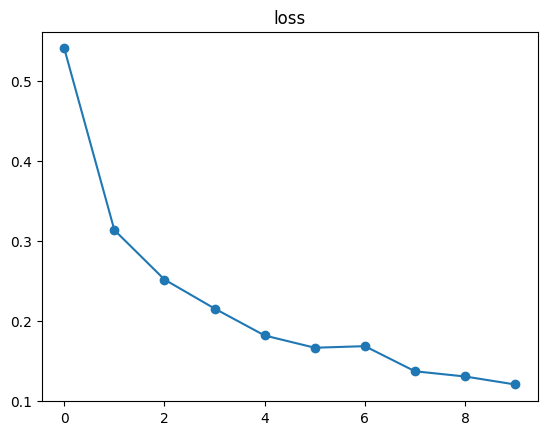

In [ ]:
from matplotlib import pyplot as plt

plt.title('loss')
plt.plot(history.history['loss'],marker='o')

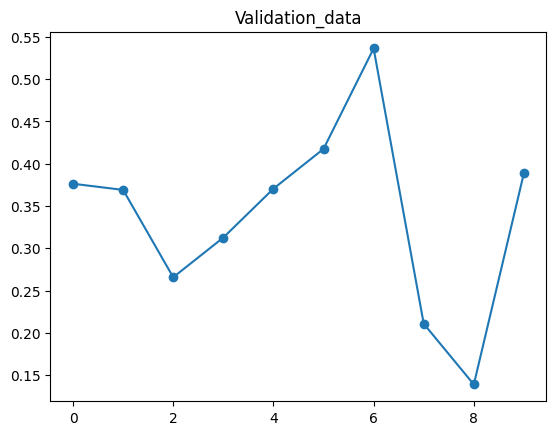

In [ ]:
plt.title('Validation_data')
plt.plot(history.history['val_loss'],marker='o')

Predicting the disease taking an input image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values between 0 and 1
    return img_array

# Replace 'path_to_individual_image.jpg' with the path to your individual image
image_array = preprocess_image('/content/drive/MyDrive/Covid-19 dataset/test/PNEUMONIA/person737_bacteria_2640.jpeg')

# Make predictions
predictions = model.predict(image_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Map the class index to the class label
class_labels = ['COVID-19', 'Fibrosis', 'Tuberculosis', 'Pneumonia', 'Normal']
predicted_label = class_labels[predicted_class]

# Print the result
print(f'Predicted class: {predicted_label}')




1/1 [==============================] - 3s 3s/step
Predicted class: Pneumonia


In [ ]:
model.save('/content/drive/MyDrive/Covid-19 dataset/diseases3.h5')